In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import glob
from collections import Counter
import math
import re
import json
import subprocess
import time
import pickle

import pandas as pd
import umap
from tqdm.autonotebook import tqdm, trange
from nltk.tokenize import word_tokenize

import numpy as np
import scipy.stats
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split, KFold

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from sklearn.utils import class_weight

from tensorflow import keras

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
#assert gpus
try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
layers = keras.layers
models = keras.models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
import numpy.random as rng
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint

import convert_model

import language
import text_nn
import grab_category
import news

In [3]:
train_folders = [os.path.join("data", folder) for folder in ["sample", "sample2", "sample3"]]
test_folders = [os.path.join("data", folder) for folder in ["sample4"]]

def load_dataset(folders):
    all_file_info = []
    all_cats = []
    all_similarities = []
    for folder in folders:
        with open(os.path.join(folder, "threads_en"), "rb") as f:
            file_info, cats, similarities = pickle.load(f)
            all_similarities.extend([[(idx + len(all_file_info), sim) for idx, sim in sims] for sims in similarities])
            all_file_info.extend(file_info)
            all_cats.extend(cats)
            
    return all_file_info, all_cats, all_similarities

train_file_info, train_cats, train_similarities = load_dataset(train_folders)
test_file_info, test_cats, test_similarities = load_dataset(test_folders)
print(f"{len(train_file_info)} train samples, {len(test_file_info)} test")

153209 train samples, 49531 test


In [4]:
def calc_popularity(similarities):
    return scipy.stats.zscore(np.log1p([sum(sim for _, sim in sims if sim > 0) for sims in similarities]))

train_popularity = calc_popularity(train_similarities)
test_popularity = calc_popularity(test_similarities)

In [5]:
top_news = list(sorted(range(len(train_popularity)), key=lambda x: train_popularity[x], reverse=True))
for i in top_news[:3]:
    print(f"{train_popularity[i]}\n\t{train_file_info[i].text[:400]}")
    print()

4.219309450530476
	2020 Grammy Awards: Full list of nominees The full list of nominees for the 2020 Grammy nominations has been released. The nomination list, which was announced on Wednesday had the Lizzo leading with eight nominations, followed by Lil Nas X and Billie Eilish, The full list of nominees for the 2020 Grammy nominations has been released. The nomination list, which was announced on Wednesday had the L

4.214661935204862
	Grammy 2020: See Complete List Of Award Nominees The Recording Academy, popularly known as the Grammy Awards on Wednesday, November 20, released the nominees list for the 2020 edition. The 62nd Annual Grammy Awards ceremony will hold in January 26, 2020, at Staples Center in Los Angeles. Nigerian afro-fusion singer, Burna Boy was nominated in the World Music category for his album ‘African Giant‘ 

4.1665064329542245
	2020 Grammy Awards: List of nominees in top categories A list of nominees in the top categories at the 62nd annual Grammy Awards, announce

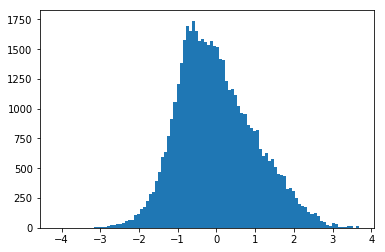

In [6]:
x = plt.hist(test_popularity, bins=100)

In [7]:
normalizer = news.TextNormalizer("english")
normalizer.train(train_file_info)
train_texts = normalizer.normalize_texts(train_file_info)
test_texts = normalizer.normalize_texts(test_file_info)

51435 word stems


In [8]:
verbose = 1
max_words = 7000
tokenize = keras.preprocessing.text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train_texts)  # fit tokenizer to our training text data
x_train = tokenize.texts_to_matrix(train_texts).astype(np.float32)
x_test = tokenize.texts_to_matrix(test_texts).astype(np.float32)

In [9]:
%reset -f in out
batch_size = 32
epochs = 100
drop_ratio = 0.5
reg = 0.01

# Build the model
model = models.Sequential()
model.add(layers.Dropout(drop_ratio, input_shape=(max_words,)))
model.add(layers.Dense(512, use_bias=True, activation="relu", kernel_regularizer=regularizers.l2(reg)))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(512, use_bias=True, activation="relu", kernel_regularizer=regularizers.l2(reg)))
model.add(layers.Dropout(drop_ratio))
model.add(layers.Dense(1, use_bias=True, kernel_regularizer=regularizers.l2(reg)))

model.compile(loss='mean_squared_error',
              optimizer=Adam(lr=0.0001), metrics=['mean_squared_error'])

model.summary()

Flushing input history
Flushing output cache (0 entries)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 7000)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               3584512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 3,847,681
Trainable params: 3,847,681
Non-trainable

In [10]:
sample_weights = np.ones_like(train_popularity)
sample_weights[train_popularity < -1] = 0.1
sample_weights[train_popularity > 0] = 2
sample_weights[train_popularity > 1] = 5
mcp_save = ModelCheckpoint('data/ranking_model_en.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(x_train, train_popularity,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=verbose,
                    #sample_weight=sample_weights,
                    validation_data=(x_test, test_popularity),
                    callbacks=[mcp_save])

model.load_weights('data/ranking_model_en.h5')

Train on 153209 samples, validate on 49531 samples
Epoch 1/100
153209/153209 [==============================] - 23s 151us/sample - loss: 2.7447 - mean_squared_error: 0.6024 - val_loss: 0.8412 - val_mean_squared_error: 0.5190
Epoch 2/100
153209/153209 [==============================] - 22s 145us/sample - loss: 0.7464 - mean_squared_error: 0.4677 - val_loss: 0.7731 - val_mean_squared_error: 0.5098
Epoch 3/100
153209/153209 [==============================] - 22s 147us/sample - loss: 0.7131 - mean_squared_error: 0.4450 - val_loss: 0.7612 - val_mean_squared_error: 0.4969
Epoch 4/100
153209/153209 [==============================] - 22s 143us/sample - loss: 0.7036 - mean_squared_error: 0.4389 - val_loss: 0.7714 - val_mean_squared_error: 0.5091
Epoch 5/100
153209/153209 [==============================] - 22s 145us/sample - loss: 0.6980 - mean_squared_error: 0.4361 - val_loss: 0.7489 - val_mean_squared_error: 0.4878
Epoch 6/100
153209/153209 [==============================] - 22s 145us/sample -

In [11]:
predicted_popularity = model.predict(x_test, verbose=0)
sample = np.random.choice(len(test_popularity), 10000)
print(np.corrcoef(test_popularity[sample], predicted_popularity[sample, 0]))
very_popular = np.flatnonzero(test_popularity > 0.5)
print(np.corrcoef(test_popularity[very_popular], predicted_popularity[very_popular, 0]))

[[1.         0.72752712]
 [0.72752712 1.        ]]
[[1.         0.36021274]
 [0.36021274 1.        ]]


In [12]:
top_news = list(sorted(range(len(predicted_popularity)), key=lambda x: predicted_popularity[x], reverse=True))
for i in top_news[:30]:
    print(f"{predicted_popularity[i]} {test_popularity[i]}\n\t{test_file_info[i].text[:400]}")
    print()

[3.144887] 0.9936277547037068
	Hold On to Your Headphones: Here Are the 2020 Grammy Nominees Grab some headphones and get excited, because the 2020 Grammy Awards nominations have arrived! After last year's big wins for Lady Gaga, Drake, and Cardi B, a new set of hopefuls are on the scene. With nominations for Billie Eilish, Ariana Grande, Lil Nas X, Lewis Capaldi, and Lizzo, we're sure to have an exciting show. Alicia Keys will

[2.593734] 2.627058047789293
	Avery Dennison Corp (NYSE:AVY) Expected to Post Quarterly Sales of $1.78 Billion Brokerages forecast that Avery Dennison Corp (NYSE:AVY) will post sales of $1.78 billion for the current fiscal quarter, Zacks Investment Research reports. Three analysts have issued estimates for Avery Dennison’s earnings, with the lowest sales estimate coming in at $1.78 billion and the highest estimate coming in at

[2.3913615] 2.4656380161647142
	Duke Energy Corp (NYSE:DUK) Expected to Announce Quarterly Sales of $6.15 Billion Wall Street analysts 

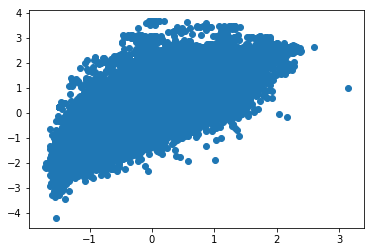

In [13]:
plt.scatter(predicted_popularity, test_popularity)

In [14]:
model.load_weights('data/ranking_model_en.h5')
model.save('data/keras_model.h5', include_optimizer=False)
convert_model.convert("data/keras_model.h5", "data/ranking_model_en.json", no_tests=False)

tokenizer_data = json.loads(tokenize.to_json())
word_index = json.loads(tokenizer_data["config"]["word_index"])
with open("data/ranking_dictionary_en.tsv", "w") as f:
    for word, index in word_index.items():
        if index < max_words:
            f.write(f"{word}\t{index}\t{normalizer.idf[word] if word in normalizer.idf else 0}\n")

loading data/keras_model.h5
Forward pass took 0.051752 s.
Forward pass took 0.004911 s.
Forward pass took 0.004435 s.
Starting performance measurements.
Forward pass took 0.002673 s.
Forward pass took 0.002665 s.
Forward pass took 0.002624 s.
Forward pass took 0.002673 s.
Forward pass took 0.002725 s.
Forward pass took 0.002672 s on average.
Converting model architecture.
Converting model weights.
Done converting model weights.
Calculating model hash.
Model conversion finished.
writing data/ranking_model_en.json


In [15]:
cpp_preds = news.run_nn(test_file_info, "english", "data/ranking_model_en.json", "data/ranking_dictionary_en.tsv")

In [16]:
cpp_preds = np.array(cpp_preds)
np.corrcoef(predicted_popularity[:, 0], cpp_preds[:, 0])

array([[1., 1.],
       [1., 1.]])

In [17]:
top_news = list(sorted(range(len(cpp_preds)), key=lambda x: cpp_preds[x], reverse=True))
for i in top_news[:30]:
    print(f"{cpp_preds[i]} {test_popularity[i]}\n\t{test_file_info[i].text[:400]}")
    print()

[3.1449] 0.9936277547037068
	Hold On to Your Headphones: Here Are the 2020 Grammy Nominees Grab some headphones and get excited, because the 2020 Grammy Awards nominations have arrived! After last year's big wins for Lady Gaga, Drake, and Cardi B, a new set of hopefuls are on the scene. With nominations for Billie Eilish, Ariana Grande, Lil Nas X, Lewis Capaldi, and Lizzo, we're sure to have an exciting show. Alicia Keys will

[2.5937] 2.627058047789293
	Avery Dennison Corp (NYSE:AVY) Expected to Post Quarterly Sales of $1.78 Billion Brokerages forecast that Avery Dennison Corp (NYSE:AVY) will post sales of $1.78 billion for the current fiscal quarter, Zacks Investment Research reports. Three analysts have issued estimates for Avery Dennison’s earnings, with the lowest sales estimate coming in at $1.78 billion and the highest estimate coming in at

[2.3914] 2.4656380161647142
	Duke Energy Corp (NYSE:DUK) Expected to Announce Quarterly Sales of $6.15 Billion Wall Street analysts expect 